In [182]:
import random,copy,math,time,os,csv,sys

from importlib import reload

import pystan

import pandas as pd
import numpy as np
import pymc3 as pm
import pickle
import corner

import scripts.data_processing as dp
import scripts.single_cell_inference as sc

import matplotlib.pyplot as plt

# import random,copy,math,time,os,csv,sys

# from importlib import reload

# import statsmodels.api as st
# import pandas as pd
# import pymc3 as pm
# from sklearn.linear_model import LinearRegression
# import pystan

# # numpy/scipy stuff
# import numpy as np

# # plotting stuff
# import matplotlib.pyplot as plt
# import matplotlib.style
# import matplotlib as mpl
# import matplotlib.gridspec as gridspec

# %matplotlib inline
# print('Running on PyMC3 v{}'.format(pm.__version__))

In [39]:
data_directory = os.getcwd() + '/../forEthan/'
reload(dp)
data = dp.get_data(data_directory)

NoGuidedRNA
  success!
GAA-SpCas9
  success!
GAA-Cpf1
  success!
CGG-SpCas9
  success!
NonRepeatedSequence-SpCas9
  success!
GAA-SpCas9-2
  missing data!
NonRepeatedSequence-Cpf1
  success!
CTG-SpCas9
  success!


In [172]:
def fill_missing(x):
    K = len(x)
    x_new = [x[0]]
    for j in range(1,K):
        if x[j]>=x_new[-1]:
            x_new.append(x[j])
        else:
            x_new.append(x_new[-1])
    return np.array(x_new)

model = pickle.load(open('./scripts/stan_models/constant_break_rate.pkl', 'rb'))
exp = data[1]
K = len(exp['t'][0])
N = len(exp['AllCellsBF'][0,:])
m = exp['AllCellsBF'].T
r = exp['AllCellsGFP'].T
m2 = np.array([fill_missing(mk) for mk in m])
r2 = np.array([fill_missing(rk) for rk in r])

In [173]:
u = m[14]#np.array([0,0,1,2,1,33])
print(u)
print(fill_missing(u))

[1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 5 5 5 5 5 6 6 6 6 6 6 6 6 6]
[1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 5 5 5 5 5 6 6 6 6 6 6 6 6 6]


In [175]:
for k in range(N):
    tests = m2[k][1:]>=m2[k][:-1]
    if len(tests[tests==False])>0:
        print(k)
        print(m2[k])

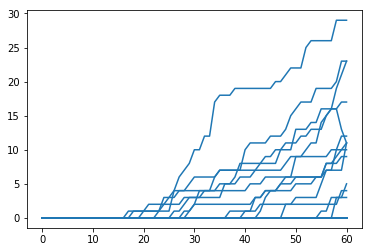

In [136]:
plt.plot(r2.T,'C0-');

In [185]:
stan_data = {'N':N,
             'K':K,
             'm':m2,
             'r':r2,
             'dt':20}
fit = model.sampling(data=stan_data, iter=10000, chains=4)

In [202]:
'/output/'+exp['experiment']

'/output/GAA-SpCas9'

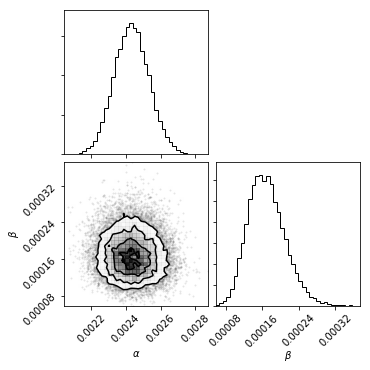

In [192]:
stacks = np.vstack([fit.extract()['alpha'],fit.extract()['beta']]).T
fig = corner.corner(stacks,bins=40,labels =[r'$\alpha$',r'$\beta$'])

[255   2   1   1   3 255   1   2   2   2   1   1   1   4   3   2   3   1
   5   1   4   2 254   8   5   6  13   4  10   5   8   6  14 252  17   9
  12]


Text(0.5, 0, 'Cells')

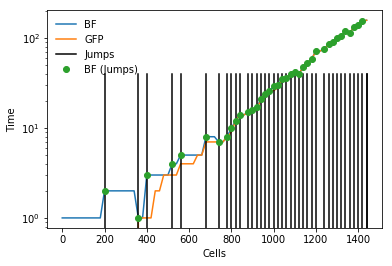

In [17]:
exp = data[5]
t = exp['t'][0]
k = 2
m,r = exp['OneCellBF'].T[k],exp['OneCellGFP'].T[k]
#print(r)
plt.plot(t,m,label='BF')
plt.plot(t,r,label='GFP')
T,jump_times,jump_cells,taus,ind_gfp = sc.get_jumps(t,m,r)
[plt.plot(t*np.ones(4),np.linspace(0,40,4),'k') for t in jump_times]
plt.plot(jump_times[-1]*np.ones(4),np.linspace(0,40,4),'k',label='Jumps')
plt.semilogy(jump_times[:-1],jump_cells,'o',label='BF (Jumps)')
print(jump_cells[1:]-jump_cells[:-1])
jump_times[:-1]
#print(T)
#print(np.dot(taus[:-1],jump_cells))
ax = plt.gca()
ax.legend(frameon=False)
ax.set_ylabel('Time')
ax.set_xlabel('Cells')

In [18]:
exp = data[1]
t = exp['t'][0]
print("Number of wells = ",len(exp['OneCellBF'].T))
for k in range(len(exp['OneCellBF'].T)):
    print('-----')
    m,r = exp['OneCellBF'].T[k],exp['OneCellGFP'].T[k]
    if np.max(r)>0:
        print(np.max(r))
        T,jump_times,jump_cells,taus,ind_gfp  = sc.get_jumps(t,m,r)
        djump_cells = jump_cells[1:]-jump_cells[:-1]
        if len(djump_cells[djump_cells>1])>0:
            print("Missing jumps at "+str(len(djump_cells[djump_cells>1]))+ " points in well " + str(k))
            print(jump_cells)
            print(djump_cells)
            print(djump_cells[djump_cells>1])

Number of wells =  27
-----
3
Missing jumps at 17 points in well 0
[ 3  4  5  7  9 11 13 17 19 23 26 27 28 32 37 40 46 47 48 57 59 67 73 77]
[1 1 2 2 2 2 4 2 4 3 1 1 4 5 3 6 1 1 9 2 8 6 4]
[2 2 2 2 4 2 4 3 4 5 3 6 9 2 8 6 4]
-----
-----
-----
5
-----
-----
-----
-----
29
Missing jumps at 4 points in well 7
[ 2  3  4  5  7  8  9 10 13 14 15 17 18 19 20 21 22 25 26 27 28]
[1 1 1 2 1 1 1 3 1 1 2 1 1 1 1 1 3 1 1 1]
[2 3 2 3]
-----
11
-----
17
Missing jumps at 4 points in well 9
[ 2  3  5  6  7 10 11 12 14 15 18]
[1 2 1 1 3 1 1 2 1 3]
[2 3 2 3]
-----
11
Missing jumps at 1 points in well 10
[ 2  3  5  6  7  8  9 10]
[1 2 1 1 1 1 1]
[2]
-----
-----
-----
-----
-----
-----
-----
-----
-----
16
Missing jumps at 8 points in well 19
[ 2  3  4  5  6  7  8 10 11 12 13 14 15 17 20 25 27 26 28 31]
[  1   1   1   1   1   1   2   1   1   1   1   1   2   3   5   2 255   2
   3]
[  2   2   3   5   2 255   2   3]
-----
9
-----
-----
23
Missing jumps at 4 points in well 22
[ 2  3  4  5  6  7  9 10 11 12 13

In [39]:
def get_cell_cycle_times(exp):
    Tgfp = []
    Tmax = []
    for k in range(len(exp['OneCellBF'].T)):
        m,r = exp['OneCellBF'].T[k],exp['OneCellGFP'].T[k]

        if np.max(r)>0: # if there is at least one gfp cell by the end
            tgfp,jump_times,jump_cells,taus,ind_gfp  = sc.get_jumps(t,m,r)
            djump_cells = jump_cells[1:]-jump_cells[:-1]
            tmax = np.dot(taus[:-1],jump_cells)
            if tgfp<tmax:
                Tgfp.append(tgfp)
                Tmax.append(tmax)
    
    return np.array(Tgfp,dtype=float),np.array(Tmax,dtype=float)

In [97]:

#plt.plot(Tgfp,Tmax,'o')
#plt.plot(Tgfp,Tgfp,'-')
#[t<g for t,g in zip(Tgfp,Tmax)]

(0, 0.005)

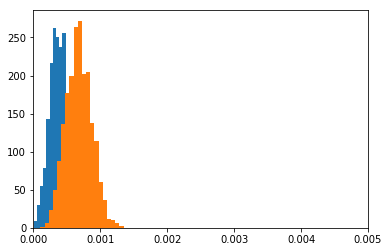

In [110]:
Tgfp,Tmax =  get_cell_cycle_times(data[2])
stan_data = {'N':len(Tgfp),
        'tgfp':Tgfp,
        'tmax': Tmax}

fit = model.sampling(data=stan_data, iter=1000, chains=4)
plt.hist(fit.extract()['beta'],20);
ax= plt.gca()
ax.set_xlim([0,0.005])

Tgfp,Tmax =  get_cell_cycle_times(data[4])
stan_data = {'N':len(Tgfp),
        'tgfp':Tgfp,
        'tmax': Tmax}

fit = model.sampling(data=stan_data, iter=1000, chains=4)
plt.hist(fit.extract()['beta'],20);
ax= plt.gca()
ax.set_xlim([0,0.005])

In [122]:
data[3]['t'][0]

array([   0,   20,   40,   60,   80,  100,  120,  140,  160,  180,  200,
        220,  240,  260,  280,  300,  320,  340,  360,  380,  400,  420,
        440,  460,  480,  500,  520,  540,  560,  580,  600,  620,  640,
        660,  680,  700,  720,  740,  760,  780,  800,  820,  840,  860,
        880,  900,  920,  940,  960,  980, 1000, 1020, 1040, 1060, 1080,
       1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300,
       1320, 1340, 1360, 1380, 1400, 1420, 1440], dtype=uint16)